# Data Dictionary

|Feature|Type|Description|
|---|---|---|
|Product_Code|*string*|The product name encoded|
|Warehouse|*string*|Warehouse ID|
|Product_Category|*string*|Product category of each product|
|Date|*string*|The date customer needs the product|
|Order_Demand|*string*|Order quantity|

In [1]:
# Import libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Read csv file and display shape.
df = pd.read_csv('../Data_Historical/df2.csv').iloc[:,1:]
df.shape

(924272, 5)

In [3]:
# Queries all rows of Product 1359.
df_1359 = df[df['Product_Code']=='Product_1359']
df_1359.shape

(10859, 5)

In [4]:
df_1359.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
1060,Product_1359,Whse_J,Category_019,2012-01-05,25000
1242,Product_1359,Whse_J,Category_019,2012-01-05,1000
1285,Product_1359,Whse_J,Category_019,2012-01-05,10000
1295,Product_1359,Whse_J,Category_019,2012-01-05,5000
1307,Product_1359,Whse_J,Category_019,2012-01-05,150000


In [5]:
# Convert Date to datetime format.
df_1359['Date'] = pd.to_datetime(df_1359['Date'])

# Set Date as index.
df_1359 = df_1359.set_index('Date')

C:\Users\Zeonice\AppData\Local\Temp\ipykernel_1980\1628588094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1359['Date'] = pd.to_datetime(df_1359['Date'])


In [6]:
# Resample Order Demand of Product 1359 to weekly sales in the multiple of 1000.
prod_1359 = (df_1359['Order_Demand']/1000).resample('W').sum()

Text(0.5, 1.0, 'Product 1359 weekly sales')

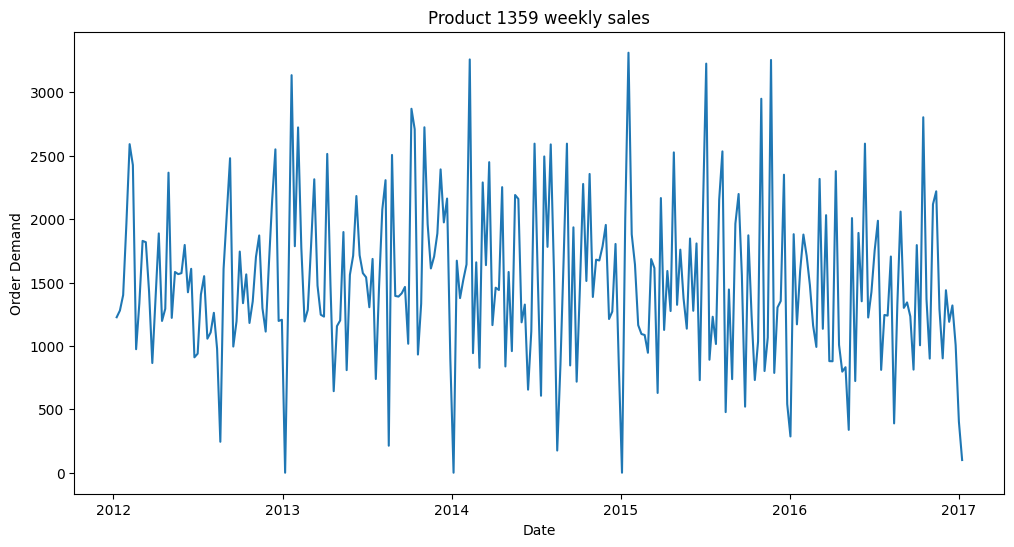

In [7]:
plt.figure(figsize=(12,6))
plt.plot(prod_1359);
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.title('Product 1359 weekly sales')

From the glance of the graph, the data does not seem to be stationary. However, we are not 100% sure yet

In [8]:
# Convert the data to Data Frame.
prod_1359 = pd.DataFrame(prod_1359)
prod_1359.rename(columns={'Order_Demand':'demand'},inplace=True)
prod_1359.head(3)

,demand
Date,
2012-01-08,1226.0
2012-01-15,1279.0
2012-01-22,1401.0


In [9]:
# Run ADF test on original (non-differenced!) data.
adfuller(prod_1359['demand'])

(-11.288554988001893,
 1.398222410142392e-20,
 2,
 259,
 {'1%': -3.4558530692911504,
  '5%': -2.872764881778665,
  '10%': -2.572751643088207},
 3860.466423590911)

In [10]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [11]:
# Run ADF test on original (non-differenced!) data.

interpret_dftest(adfuller(prod_1359['demand']))

Test Statistic   -1.128855e+01
p-value           1.398222e-20
dtype: float64

At $\alpha$ = 0.01, $p$-value is smaller than $\alpha$ and hence we can accept the demand is stationary.

In [12]:
# Check size of prod_1359.
prod_1359.shape

(262, 1)

# Baseline Model

In [13]:
# Create train-test split.
y_train = prod_1359[0:(prod_1359.shape[0]-4)]
y_test = prod_1359[(prod_1359.shape[0]-4):]

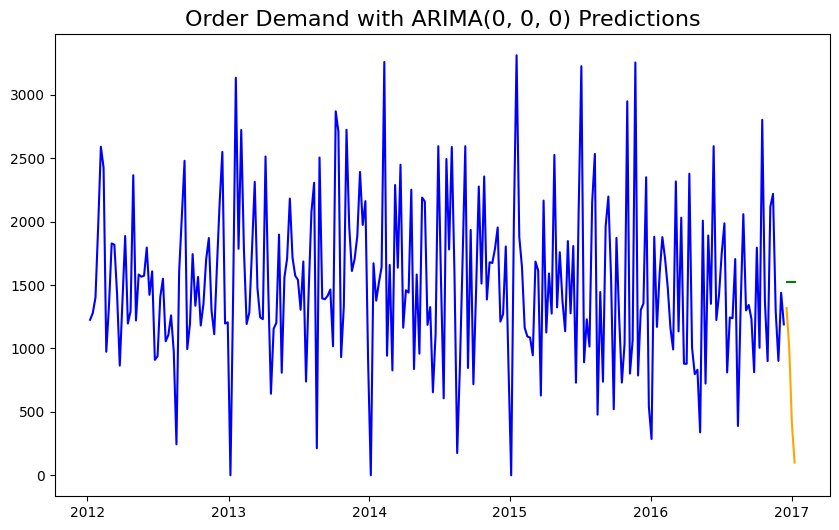

In [14]:
# Instantiate baseline model.
arima = ARIMA(endog=y_train, order=(0, 0, 0))


# Fit ARIMA model.
model = arima.fit()

# Generate predictions based on test set.
preds = model.predict(start=y_test.index[0], end = y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Order Demand with ARIMA(0, 0, 0) Predictions', fontsize=16)
plt.show();

In [15]:
rmse_base = mean_squared_error(y_test, preds, squared=False)*1000
rmse_base

945849.7020601606

RMSE of the baseline model is 945,849. We will further optimize the model.

# ARIMA

In [18]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 0, q) model.
            print(f'Attempting ARIMA({p}, 0, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog=y_train, order=(p, 0, q))
            
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 0, q) model.
            print(f'The AIC for ARIMA({p},0,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},0,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting ARIMA(0, 0, 0)
The AIC for ARIMA(0,0,0) is: 4059.2770075653953
Attempting ARIMA(0, 0, 1)
The AIC for ARIMA(0,0,1) is: 4060.111628413215
Attempting ARIMA(0, 0, 2)
The AIC for ARIMA(0,0,2) is: 4053.470236163391
Attempting ARIMA(0, 0, 3)
The AIC for ARIMA(0,0,3) is: 4053.0353057409093
Attempting ARIMA(0, 0, 4)
The AIC for ARIMA(0,0,4) is: 4054.4410304664098
Attempting ARIMA(1, 0, 0)
The AIC for ARIMA(1,0,0) is: 4060.527610059648
Attempting ARIMA(1, 0, 1)
The AIC for ARIMA(1,0,1) is: 4055.528607216278
Attempting ARIMA(1, 0, 2)


C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(1,0,2) is: 4054.1031627253396
Attempting ARIMA(1, 0, 3)
The AIC for ARIMA(1,0,3) is: 4054.6698229200597
Attempting ARIMA(1, 0, 4)
The AIC for ARIMA(1,0,4) is: 4056.330345512697
Attempting ARIMA(2, 0, 0)
The AIC for ARIMA(2,0,0) is: 4054.969570205233
Attempting ARIMA(2, 0, 1)
The AIC for ARIMA(2,0,1) is: 4053.3204149811754
Attempting ARIMA(2, 0, 2)
The AIC for ARIMA(2,0,2) is: 4054.913230506564
Attempting ARIMA(2, 0, 3)
The AIC for ARIMA(2,0,3) is: 4056.0211580636983
Attempting ARIMA(2, 0, 4)
The AIC for ARIMA(2,0,4) is: 4054.85343673691
Attempting ARIMA(3, 0, 0)
The AIC for ARIMA(3,0,0) is: 4052.3658174751013
Attempting ARIMA(3, 0, 1)
The AIC for ARIMA(3,0,1) is: 4054.37276203623
Attempting ARIMA(3, 0, 2)
The AIC for ARIMA(3,0,2) is: 4056.335790620531
Attempting ARIMA(3, 0, 3)
The AIC for ARIMA(3,0,3) is: 4055.323141611292
Attempting ARIMA(3, 0, 4)
The AIC for ARIMA(3,0,4) is: 4056.4887727407236
Attempting ARIMA(4, 0, 0)
The AIC for ARIMA(4,0,0) is: 4054.372883565071


C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(4,0,2) is: 4058.294746856772
Attempting ARIMA(4, 0, 3)


C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters foun

The AIC for ARIMA(4,0,3) is: 4059.3590526527346
Attempting ARIMA(4, 0, 4)
The AIC for ARIMA(4,0,4) is: 4058.352785262674


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(3,0,0).
This model has an AIC of 4052.3658174751013.


C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


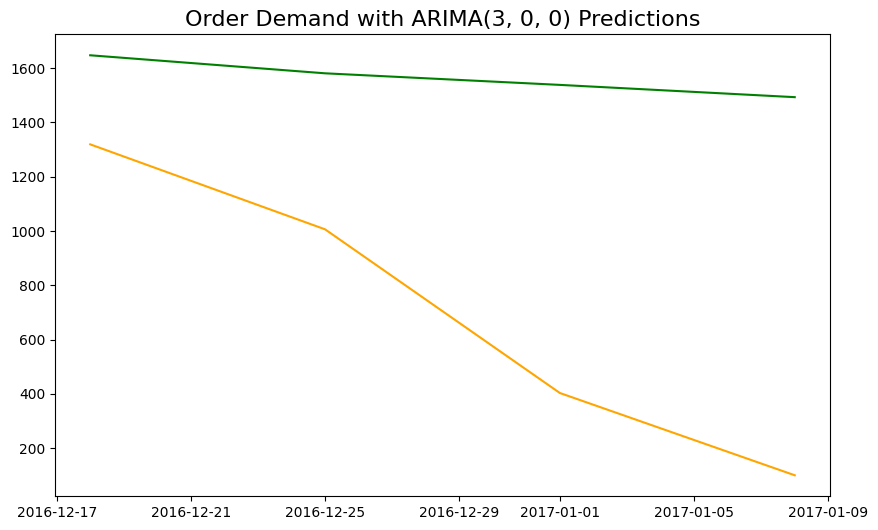

In [16]:
# Instantiate best model.
arima = ARIMA(endog=y_train, order=(3, 0, 0))


# Fit ARIMA model.
model = arima.fit()

# Generate predictions based on test set.
preds = model.predict(start=y_test.index[0], end = y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Order Demand with ARIMA(3, 0, 0) Predictions', fontsize=16)
plt.show();

In [17]:
rmse_base = mean_squared_error(y_test, preds, squared=False)*1000
rmse_base

957380.050713796

The trend seems to fit the testing data more than the baseline model, however, the RMSE is higher than baseline model. This is acceptable since we have not included the seasonal factor.

# SARIMAX

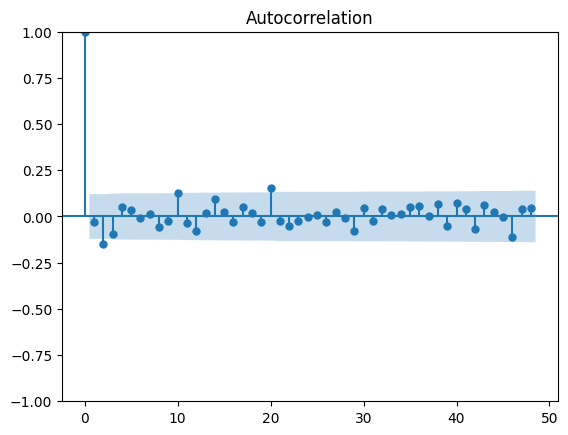

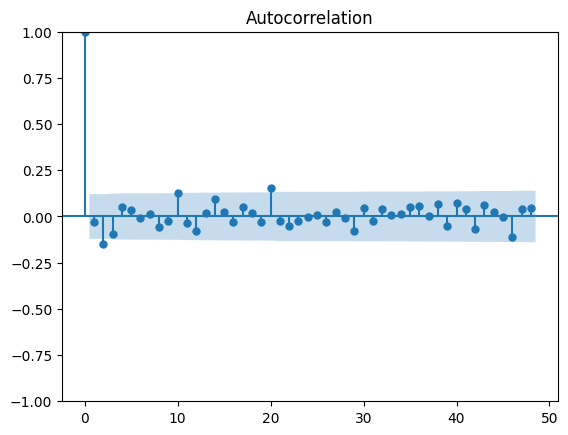

In [18]:
# Generate autocorrelation plot on training data.
plot_acf(prod_1359['demand'], lags = 48)

C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


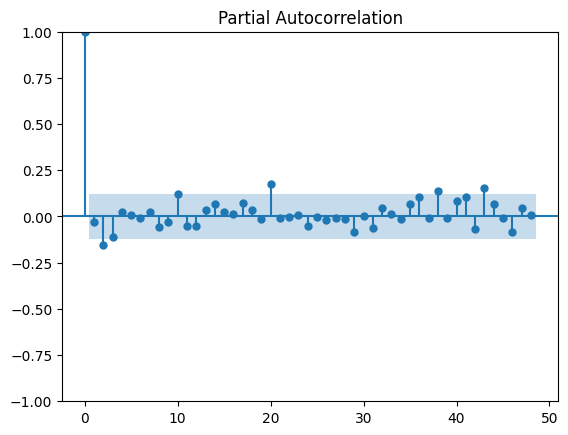

In [19]:
plot_pacf(prod_1359['demand'], lags = 48);

Seems like the data has the highest correlation at lag = 20.

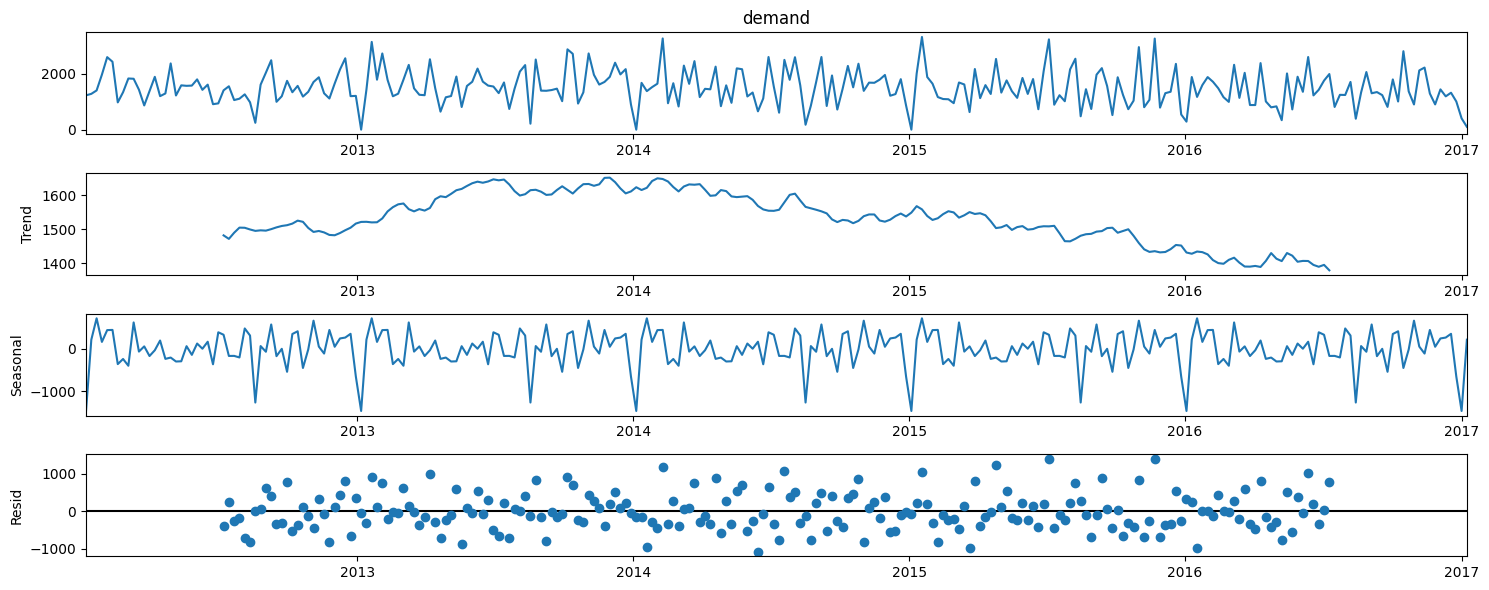

In [20]:
rcParams['figure.figsize'] = 15, 6
decomposition = sm.tsa.seasonal_decompose(prod_1359['demand'], model='additive', period = 52)
fig = decomposition.plot()
plt.show()

In [23]:
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0

for P in range(5):
    for Q in range(5):
        for D in range(5):
            try:
                # Instantiate SARIMA model.
                sarima = SARIMAX(endog = y_train,
                                 order = (3, 0, 0),              # (p, d, q)
                                 seasonal_order = (P, D, Q, 20)) # (P, D, Q, S)

                # Fit SARIMA model.
                model = sarima.fit()

                # Generate predictions based on training set.
                # Start at time period 0 and end at 149.
                preds = model.predict(start=0, end=(prod_1359.shape[0]-4))

                # Evaluate predictions.
                print(f'The MSE for (3, 0, 0)x({P},{D},{Q},20) is: {mean_squared_error(y_train, preds)}')
                
                # Save for final report.
                if mse > mean_squared_error(y_train, preds):
                    mse = mean_squared_error(y_train, preds)
                    final_P = P
                    final_D = D
                    final_Q = Q
                
            except:
                pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(3, 0, 0)x({final_P},{final_D},{final_Q},20).')
print(f'This model has an MSE of {mse}.')

C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal

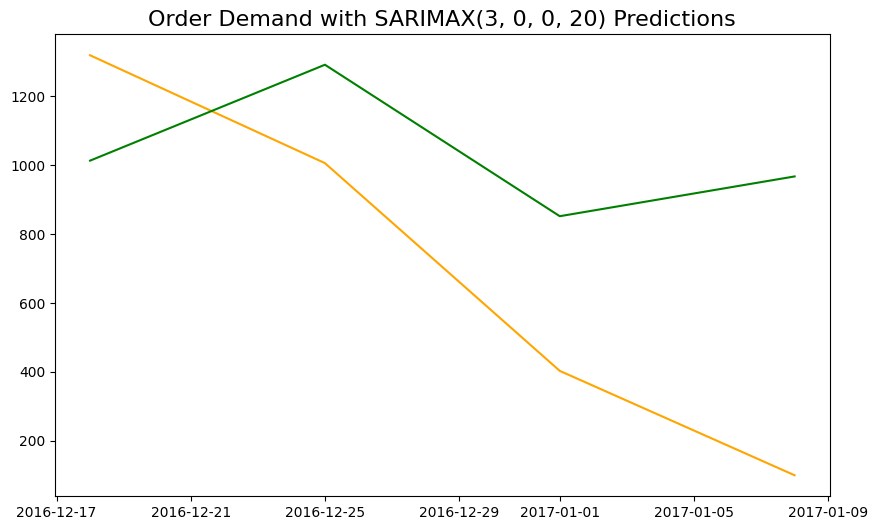

In [21]:
# Instantiate SARIMA model.
sarima = SARIMAX(endog = y_train,
                order = (3, 0, 0),              # (p, d, q)
                seasonal_order = (3, 0, 0, 20)) # (P, D, Q, S)


# Fit ARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=y_test.index[0], end = y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Order Demand with SARIMAX(3, 0, 0, 20) Predictions', fontsize=16)
plt.show();

In [22]:
rmse_base = mean_squared_error(y_test, preds, squared=False)*1000
rmse_base

531252.1330218492

RMSE has been greatly reduced to 532,152, almost half of the RMSE of baseline model.

In [23]:
# There are 534 different products in Category 019.
cat_019 = df[df['Product_Category']=='Category_019']['Product_Code'].unique()
len(cat_019)

534

In [24]:
# Calculate correlation of all category 019 products.
all_cat_019 = pd.DataFrame()
for code in cat_019:
    df_init = df[df['Product_Code']==code]
    df_init['Date'] = pd.to_datetime(df_init['Date'])
    df_init = df_init.set_index('Date')
    df_init = pd.DataFrame((df_init['Order_Demand']).resample('W').sum())
    df_init.rename(columns={'Order_Demand':code},inplace=True)
    all_cat_019 = pd.concat([all_cat_019,df_init],axis=1)

cat_019_corr = all_cat_019.corr()

C:\Users\Zeonice\AppData\Local\Temp\ipykernel_1980\1544936339.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_init['Date'] = pd.to_datetime(df_init['Date'])
C:\Users\Zeonice\AppData\Local\Temp\ipykernel_1980\1544936339.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_init['Date'] = pd.to_datetime(df_init['Date'])
C:\Users\Zeonice\AppData\Local\Temp\ipykernel_1980\1544936339.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [25]:
# Product_0096 has the highest correlation with Product_1359.
cat_019_corr['Product_1359'].sort_values(ascending=False)

Product_1359    1.000000
Product_0096    0.452569
Product_1274    0.374437
Product_1463    0.340803
Product_1414    0.325969
                  ...   
Product_1267   -0.100338
Product_0838   -0.102821
Product_0834   -0.109613
Product_0071   -0.118914
Product_2151   -0.231448
Name: Product_1359, Length: 534, dtype: float64

In [26]:
# Clean Order Demand of Product 0096.
code = 'Product_0096'
df_0096 = df[df['Product_Code']==code]
df_0096['Date'] = pd.to_datetime(df_0096['Date'])
df_0096 = df_0096.set_index('Date')
df_0096 = pd.DataFrame((df_0096['Order_Demand']).resample('W').sum())
df_0096.rename(columns={'Order_Demand':'dem_0096'},inplace=True)

C:\Users\Zeonice\AppData\Local\Temp\ipykernel_1980\1459431264.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0096['Date'] = pd.to_datetime(df_0096['Date'])


In [27]:
# Add a column for demand of Product 0096.
prods = pd.concat([prod_1359, df_0096],axis =1).fillna(0)
prods

,demand,dem_0096
Date,,
2012-01-08,1226.0,0.0
2012-01-15,1279.0,0.0
2012-01-22,1401.0,0.0
2012-01-29,1964.0,0.0
2012-02-05,2591.0,0.0
...,...,...
2016-12-11,1190.0,20500.0
2016-12-18,1319.0,13000.0
2016-12-25,1006.0,28000.0


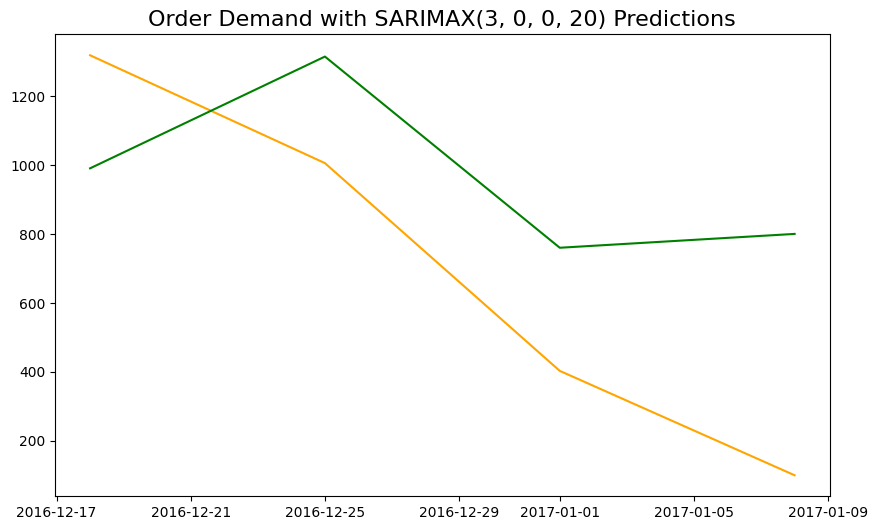

In [29]:
# Instantiate SARIMA model with exogenous feature.
sarima = SARIMAX(endog = y_train,
                order = (3, 0, 0),              # (p, d, q)
                seasonal_order = (3, 0, 0, 20), # (P, D, Q, S)
                exog = prods['dem_0096'].iloc[0:(prod_1359.shape[0]-4)])


# Fit ARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=y_test.index[0], end = y_test.index[-1], exog = prods['dem_0096'].iloc[(prod_1359.shape[0]-4):])

# Plot data.
plt.figure(figsize=(10,6))

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Order Demand with SARIMAX(3, 0, 0, 20) Predictions', fontsize=16)
plt.show();

In [32]:
rmse_sarimax = mean_squared_error(y_test, preds, squared=False)*1000
rmse_sarimax

453255.1496509979

The RMSE is improved to 453255. We will try Neural Network in the next part.